# Load Packages

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths to datasets


In [25]:
paths = {
    "Raw": "../../data/processed/training_numeric_cleaned.csv",
    "IQR": "../../data/processed/training_outlier_removed.csv",
    "Winsorized": "../../data/processed/training_winsorized.csv"
}

# Define target column

In [26]:
target_col = "ActualTOW"

# Dictionary to store results

In [27]:
results = {}

for label, path in paths.items():
    print(f"\n📂 Dataset: {label}")
    
    # 1. Load data
    df = pd.read_csv(path, sep="\t")

    # 2. Select numerical columns only (excluding encoded categories if present)
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Optional: remove non-numeric columns (in case one-hot not used yet)
    X = X.select_dtypes(include=[np.number])

    # 3. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 4. Train Linear Regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 5. Predict and evaluate
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    results[label] = {"RMSE": rmse, "MAE": mae}
    print(f"🔍 RMSE: {rmse:.2f} | MAE: {mae:.2f}")


📂 Dataset: Raw
🔍 RMSE: 1010.30 | MAE: 749.21

📂 Dataset: IQR
🔍 RMSE: 929.90 | MAE: 682.16

📂 Dataset: Winsorized
🔍 RMSE: 938.48 | MAE: 685.67


c:\Users\huber\anaconda3\envs\ryanair_regression\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\huber\anaconda3\envs\ryanair_regression\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\huber\anaconda3\envs\ryanair_regression\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Compare results

In [28]:
print("\n📊 Summary of Results:")
for key, metrics in results.items():
    print(f"{key:12} → RMSE: {metrics['RMSE']:.2f} | MAE: {metrics['MAE']:.2f}")
    


📊 Summary of Results:
Raw          → RMSE: 1010.30 | MAE: 749.21
IQR          → RMSE: 929.90 | MAE: 682.16
Winsorized   → RMSE: 938.48 | MAE: 685.67


# Plot comparison

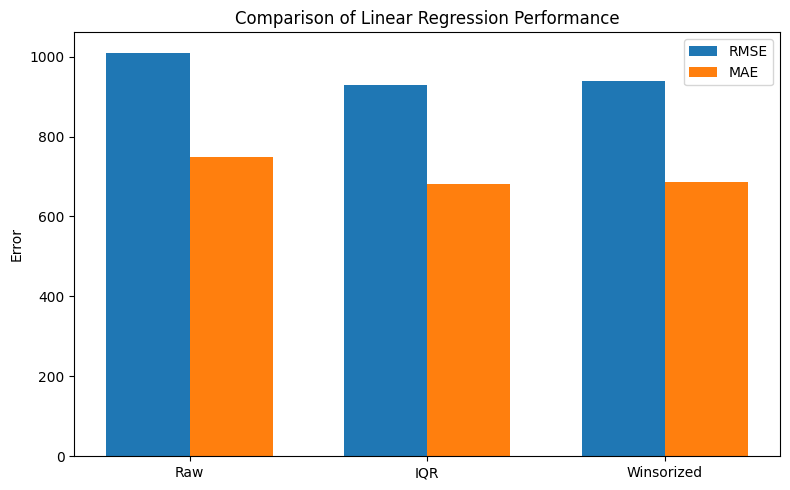

In [29]:
plt.figure(figsize=(8, 5))
labels = list(results.keys())
rmse_vals = [results[k]['RMSE'] for k in labels]
mae_vals = [results[k]['MAE'] for k in labels]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, rmse_vals, width, label='RMSE')
plt.bar(x + width/2, mae_vals, width, label='MAE')

plt.xticks(x, labels)
plt.ylabel("Error")
plt.title("Comparison of Linear Regression Performance")
plt.legend()
plt.tight_layout()
plt.show()